# Energy transition from fossil fuels to solar and wind

This notebook presents an over-simplified way to make an estimate of how long it might take to phase out fossil fuels and illustrates a rather over-simplified way for how a logistic growth model might be applied to the uptake of solar and wind energy.

The approach makes the following assumptions...

* A model for energy demand this century.

* Fossil fuels will primarily be replaced by solar and wind.

* Nuclear, hydro, biofuels, and other renewables ('other') don't change much.

* Solar and wind energy have logistic growth with:   
(1) growth factors estimated from recent trends; and  
(2) carrying capacity equal to the total potential market (existing capacity + fossil fuel share).

First, import packages, recover our future projection of total energy demand, and load energy data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Force use of TrueType fonts in pdfs for later editing
from matplotlib import rc
rc("pdf", fonttype=42)

#------------- load model and historical data ----------------------------------------
# Model of total energy consumption
t = np.load('t.npy')
modelEnergyTotal = np.load('energyModel2100_TWh-yr.npy')

# Data of historical values
dataDir = '../DATA/energy-consumption/'
filename = dataDir + 'global-primary-energy.csv'
year = np.genfromtxt(filename,delimiter=',',skip_header=1,usecols=(2,))
energy = np.genfromtxt(filename,delimiter=',',skip_header=1,
                       usecols=np.arange(3,12))
energyType = ['Coal','Solar','Oil','Gas','Traditional biofuels',
              'Other renewables','Hydro','Nuclear','Wind']
eSolar  = energy[:,1]
eWind   = energy[:,8]
eFossil = energy[:,0] + energy[:,2] + energy[:,3]
eOther  = energy[:,4] + energy[:,5] + energy[:,6] + energy[:,7] 


## Plot historical data

When we plot historical data, we see that 'other' types of energy don't really vary that much and uncertainties in this number don't result in poor confidence of our projection. It is striking just how small the total contribution from solar and wind currently is - but it is growing exponentially!

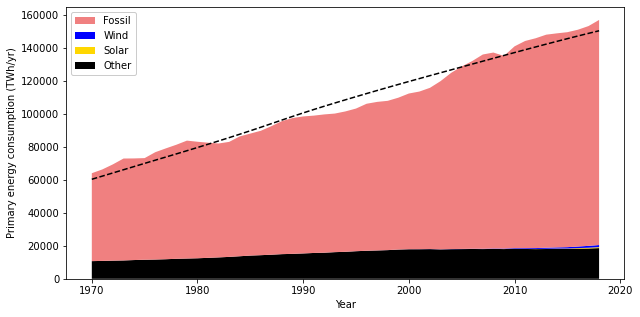

In [2]:
plt.figure(figsize=[10,5])

sel = (year >= 1970) & (year <= 2018)
eValues = (eOther[sel],eSolar[sel],eWind[sel],eFossil[sel])
eLabels = ('Other','Solar','Wind','Fossil')
eColors = ('black','gold','blue','lightcoral')
plt.stackplot(year[sel],eValues,labels=eLabels,colors=eColors)

plt.legend(reversed(plt.legend().legendHandles), reversed(eLabels),
           loc='upper left', framealpha=1.0 )

sel2 = (t >= 1970) & (t <= 2018)
plt.plot(t[sel2],modelEnergyTotal[sel2],linestyle='--')

plt.xlabel('Year')
plt.ylabel('Primary energy consumption (TWh/yr)')
plt.savefig("energyTransition1.pdf")


##  Growth of solar and wind energy
We can approximate growth of energy consumption $E$ with an exponential model.

\begin{equation}  \frac{dE}{dt} = k E  \end{equation} 

\begin{equation}  \frac{d(\ln E)}{dt} = k  \end{equation} 

We can find the growth factor, $k$ by looking at the gradient of $\ln E$ plotted against $t$.

In [3]:
select = (year >= 1995)

modelParametersSolar = np.polyfit(year[select],np.log(eSolar[select]),1)
modelParametersWind = np.polyfit(year[select],np.log(eWind[select]),1)

kSolar = modelParametersSolar[0]
kWind = modelParametersWind[0]

print('Growth factor, Solar =',kSolar,'; Growth factor, Wind =',kWind,', year on year proportional increase.')

Growth factor, Solar = 0.33066623069143625 ; Growth factor, Wind = 0.22924168551720323 , year on year proportional increase.


### Student exercise  

Plot a graph showing data used for the fit and the regression line through those data. Use a log scale `plt.yscale('log')`. Are the gradients of the data reasonably constant? We find a growth factor $k$ by determining the gradient of each line (the first model parameter). Does the choice of years used for the fit make a great deal of difference?

## Logistic growth  
We assume growth of solar and wind continues according to a logistic growth model. Exponential processes run up against capacity issues as they grow. The current proportion of energy provided by wind and solar is very small, so is approximately exponential, but this can't carry on indefinitely.

\begin{equation}  dE = k E \left(1 - \frac{E}{P} \right) dt \end{equation} 

where $E$ is the value of energy produced at time $t$ by either solar or wind, and $P$ is the maximum capacity for that energy type, which is the current value of $E + E_{fossil}$. The remaining fossil fuel energy use is a gap needing to be filled!

We do not have to solve this differential equation. We can simply add up all the differences - a finite difference method. We start at the end of the historical data, then append values to each array until we have filled in all the model values.


In [4]:
iStart = np.where(t == year[-1])[0][0] + 1

for i in range(iStart, len(t)) :
    year = np.append(year,t[i])
    # append the same value of eOther, i.e. the last value in the array
    eOther = np.append(eOther,eOther[-1])
    # Solar
    P = eSolar[-1] + eFossil[-1]
    dE = kSolar * eSolar[-1] * (1 - eSolar[-1] / P)
    eSolar = np.append(eSolar, eSolar[-1] + dE)
    # Wind
    P = eWind[-1] + eFossil[-1]
    dE  = kWind * eWind[-1] * (1 - eWind[-1] / P)
    eWind  = np.append(eWind ,  eWind[-1] + dE)
    # Fossil fuels is what is left
    eFossil = np.append(eFossil,
                     modelEnergyTotal[i] - eOther[-1] - eSolar[-1] - eWind[-1])

np.save('eYear.npy',year)
np.save('eFossil.npy',eFossil)
np.save('eSolar.npy',eSolar)
np.save('eWind.npy',eWind)
np.save('eOther.npy',eOther)

## Plot the energy transition


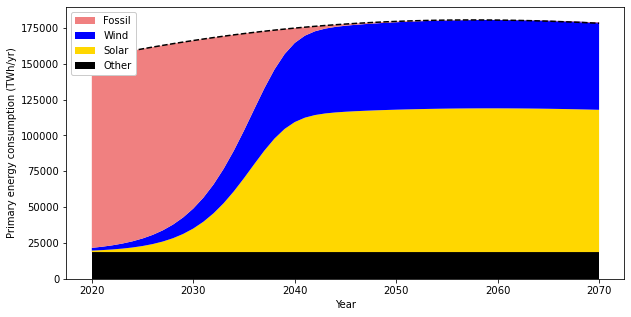

In [5]:
plt.figure(figsize=[10,5])

sel = (year >= 2020) & (year <= 2070)
eValues = (eOther[sel],eSolar[sel],eWind[sel],eFossil[sel])
eLabels = ('Other','Solar','Wind','Fossil')
eColors = ('black','gold','blue','lightcoral')
plt.stackplot(year[sel],eValues,labels=eLabels,colors=eColors)

plt.legend(reversed(plt.legend().legendHandles), reversed(eLabels),
           loc='upper left', framealpha=1.0 )

sel2 = (t >= 2020) & (t <= 2070)
plt.plot(t[sel2],modelEnergyTotal[sel2],linestyle='--')

plt.xlabel('Year')
plt.ylabel('Primary energy consumption (TWh/yr)')
plt.savefig("energyTransition2.pdf")

## Discussion
Let's discuss this rather amazing (optimistic) result. What were our assumptions? Are any in significant doubt?